In [67]:
%matplotlib inline
from imp import reload
import pickle

from matplotlib import pyplot as plt
import numpy as np
import torch as th
from torch.utils.data import DataLoader
import ttools

from dps_3d import datasets, utils
from dps_3d.interfaces import VectorizerInterface
from dps_3d.models import PrimsModel

In [5]:
th.manual_seed(123)
th.backends.cudnn.deterministic = True
np.random.seed(123)

In [6]:
data = datasets.ShapenetDataset('data/chairs', 64)
dataloader = DataLoader(data)

In [7]:
model = PrimsModel(output_dim=11*16)

In [8]:
checkpointer = ttools.Checkpointer('output/test', model)
checkpointer.load_latest()

({'epoch': 191}, None)

In [94]:
x['fname']

'100b18376b885f206ae9ad7e32c4139d'

In [102]:
with th.no_grad():
    x = data[3]
    target_distance_fields = x['distance_fields']
    target_occupancy_fields = x['occupancy_fields']
    params = model(target_distance_fields[None,None])

In [103]:
params = params.view(params.size(0), 16, -1).detach()
params = th.cat([0.3*th.sigmoid(params[...,:3])+0.05,
                 params[...,3:6],
                 0.8*th.sigmoid(params[...,6:10])+0.1,
                 th.sigmoid(params[...,10:])], dim=-1)

In [104]:
distance_fields = utils.compute_distance_fields(params, 64,
                                                df=utils.distance_to_rounded_cuboids).abs()
distance_fields = distance_fields.min(1)[0]
alignment_fields = utils.compute_alignment_fields(distance_fields)
distance_fields = distance_fields[...,1:-1,1:-1,1:-1]
occupancy_fields = utils.compute_occupancy_fields(distance_fields)

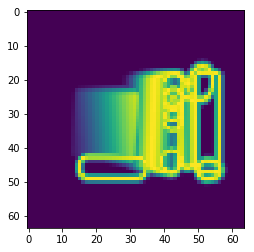

In [105]:
plt.imshow(occupancy_fields[0,:,32].detach())

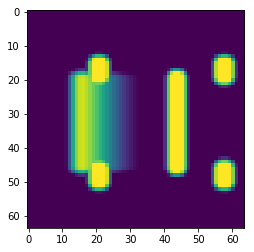

In [106]:
plt.imshow(target_occupancy_fields[:,32].detach())

In [109]:
primitives = []
for p in params[0]:
    b, q, T, r = (x.numpy() for x in th.split(p, [3, 4, 3, 1]))
    q /= np.sqrt(np.sum(q**2))
    primitives.append({
        'translation': list(T),
        'rotation': q,
        'size': b,
        'r': r
    })

[0.9999994]
[0.7818681]
[0.9999993]
[0.85044235]
[0.9999993]
[0.8621042]
[0.9999995]
[0.9999999]
[0.9059778]
[0.99999964]
[0.9623116]
[0.9999989]
[0.37229034]
[0.93950677]
[0.9736396]
[0.96766484]


In [108]:
pickle.dump(primitives, open('boxes', 'wb'))